Testing different topologies for Heron Processor...
Gate median errors:
id: 0.0002738
rx: 0.0002738
rz: 0.0
sx: 0.0002738
x: 0.0002738
cz: 0.001947
rzz: 0.00249

Testing Topo1 ...
Expected fidelity reached threshold for Topo1 , stopping early.
Topo1  completed with 5 data points

Testing Topo2 ...
Expected fidelity reached threshold for Topo2 , stopping early.
Topo2  completed with 2 data points

Testing Topo3 ...
Expected fidelity reached threshold for Topo3 , stopping early.
Topo3  completed with 10 data points

Testing Topo4 ...
Expected fidelity reached threshold for Topo4 , stopping early.
Topo4  completed with 10 data points

Testing Topo5 ...
Expected fidelity reached threshold for Topo5 , stopping early.
Topo5  completed with 7 data points


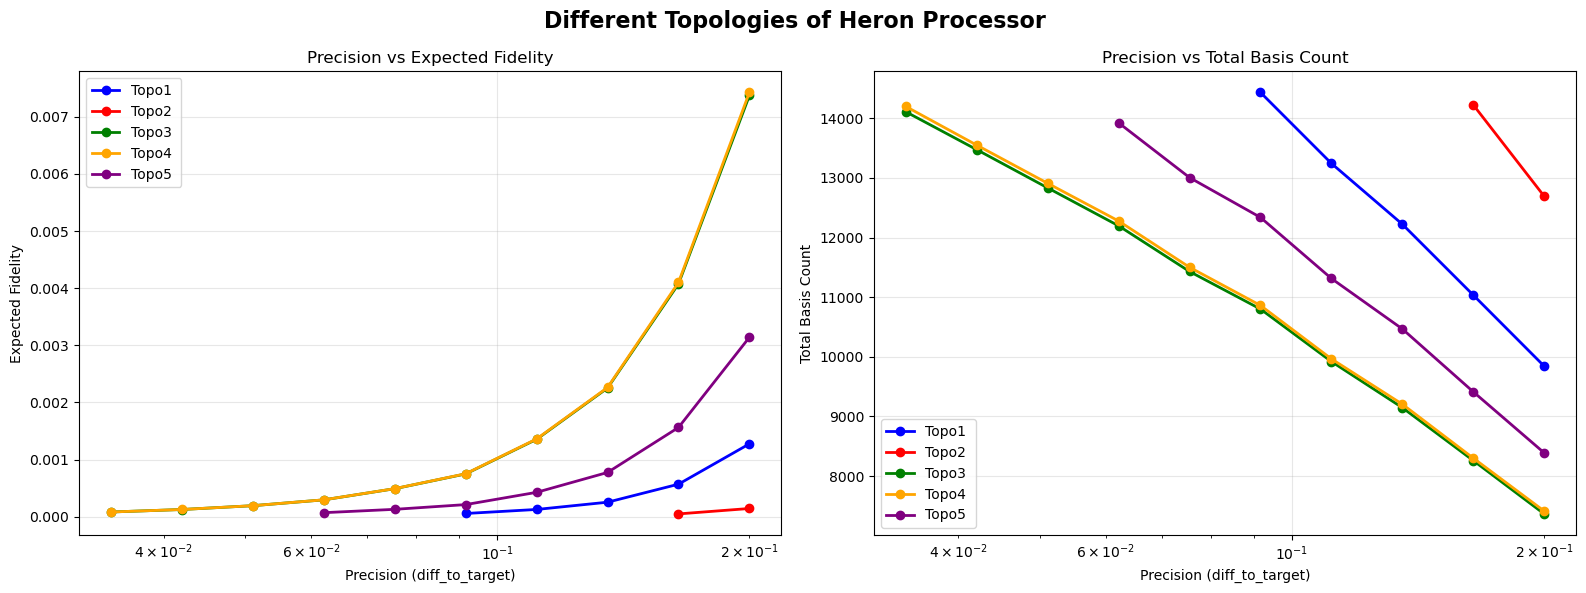


SUMMARY STATISTICS
Topo1 :
  Maximum Fidelity: 0.001276
  Minimum Gate Count: 9844
  Data Points: 5

Topo2 :
  Maximum Fidelity: 0.000144
  Minimum Gate Count: 12693
  Data Points: 2

Topo3 :
  Maximum Fidelity: 0.007373
  Minimum Gate Count: 7366
  Data Points: 10

Topo4 :
  Maximum Fidelity: 0.007428
  Minimum Gate Count: 7414
  Data Points: 10

Topo5 :
  Maximum Fidelity: 0.003141
  Minimum Gate Count: 8390
  Data Points: 7



In [2]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

# Heron processor 设置
basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
gate_error = {
    "id": 2.738e-4,
    "rx": 2.738e-4,
    "rz": 0.0,
    "sx": 2.738e-4,
    "x": 2.738e-4,
    "cz": 1.947e-3,
    "rzz": 2.490e-3
}

# 定义不同的拓扑结构
topologies = {
    "Topo1 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2 ": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# 生成精度阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)

# 存储所有拓扑的结果
all_results = {}

print("Testing different topologies for Heron Processor...")
print("Gate median errors:")
for gate, error in gate_error.items():
    print(f"{gate}: {error}")

# 对每个拓扑运行实验
for topo_name, coupling_list in topologies.items():
    print(f"\nTesting {topo_name}...")
    
    coupling_map = CouplingMap(couplinglist=coupling_list)
    fidelity_list = []
    total_count_list = []
    
    for threshold in precision_list:
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行 main_loop
        beta_list, energy_list, final_circuit = main_loop_2(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0,
            n_steps=n_steps,
            diff_threshold=threshold
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())
        total_count_list.append(total_count)

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
        fidelity_list.append(expected_fidelity)
        
        # 如果保真度太低就提前退出
        if expected_fidelity < 0.0001:
            print(f"Expected fidelity reached threshold for {topo_name}, stopping early.")
            break
    
    # 存储结果
    all_results[topo_name] = {
        'precision': precision_list[:len(fidelity_list)],
        'fidelity': fidelity_list,
        'gate_count': total_count_list
    }
    
    print(f"{topo_name} completed with {len(fidelity_list)} data points")

# 绘制合并图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Different Topologies of Heron Processor', fontsize=16, fontweight='bold')

# 定义颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Plot 1: Precision vs Expected Fidelity
for i, (topo_name, results) in enumerate(all_results.items()):
    ax1.plot(results['precision'], results['fidelity'], 
             marker='o', label=topo_name, color=colors[i % len(colors)], linewidth=2)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
for i, (topo_name, results) in enumerate(all_results.items()):
    ax2.plot(results['precision'], results['gate_count'], 
             marker='o', label=topo_name, color=colors[i % len(colors)], linewidth=2)

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# 打印汇总统计
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
for topo_name, results in all_results.items():
    max_fidelity = max(results['fidelity'])
    min_gate_count = min(results['gate_count'])
    print(f"{topo_name}:")
    print(f"  Maximum Fidelity: {max_fidelity:.6f}")
    print(f"  Minimum Gate Count: {min_gate_count}")
    print(f"  Data Points: {len(results['fidelity'])}")
    print()

Testing different topologies for Eagle Processor...
Gate median errors:
ecr: 0.005824
id: 0.0002252
rz: 0.0
sx: 0.0002252
x: 0.0002252

Testing Topo1 ...
Expected fidelity reached threshold for Topo1 , stopping early.
Topo1  completed with 1 data points

Testing Topo2 ...
Expected fidelity reached threshold for Topo2 , stopping early.
Topo2  completed with 1 data points

Testing Topo3 ...
Expected fidelity reached threshold for Topo3 , stopping early.
Topo3  completed with 1 data points

Testing Topo4 ...
Expected fidelity reached threshold for Topo4 , stopping early.
Topo4  completed with 1 data points

Testing Topo5 ...
Expected fidelity reached threshold for Topo5 , stopping early.
Topo5  completed with 1 data points


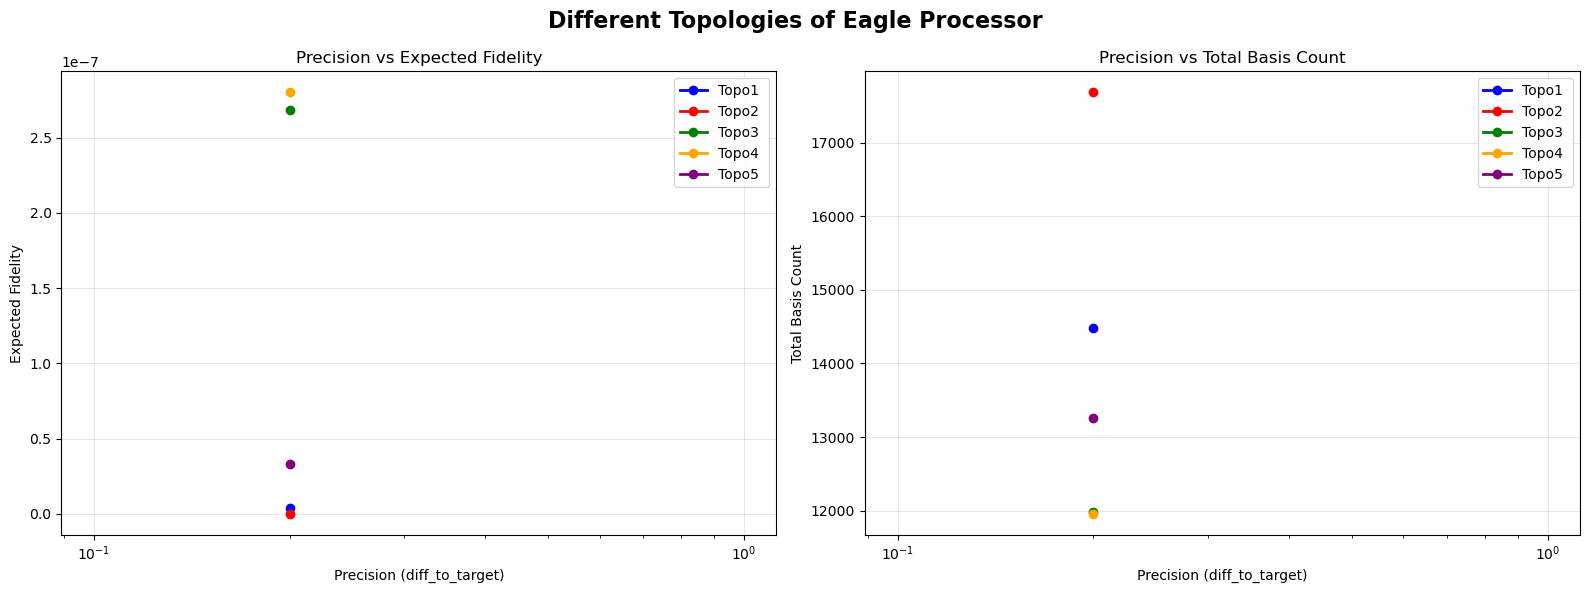


SUMMARY STATISTICS FOR EAGLE PROCESSOR
Topo1 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 14482
  Data Points: 1

Topo2 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 17684
  Data Points: 1

Topo3 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11984
  Data Points: 1

Topo4 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11956
  Data Points: 1

Topo5 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 13258
  Data Points: 1

KEY DIFFERENCES FROM HERON PROCESSOR:
- Basis gates: ['ecr', 'id', 'rz', 'sx', 'x'] (vs ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'])
- ECR gate error: 5.824e-3 (higher than Heron's CZ: 1.947e-3)
- Single-qubit gate errors: 2.252e-4 (lower than Heron's 2.738e-4)
- No native RZZ gate available


In [2]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

# Eagle processor 设置
basis_gates_eagle = ['ecr', 'id', 'rz', 'sx', 'x']
gate_error_eagle = {
    "ecr": 5.824e-3,      
    "id": 2.252e-4,      
    "rz": 0.0,           
    "sx": 2.252e-4,      
    "x": 2.252e-4,       
}

# 定义不同的拓扑结构
topologies = {
    "Topo1 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2 ": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# 生成精度阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)

# 存储所有拓扑的结果
all_results = {}

print("Testing different topologies for Eagle Processor...")
print("Gate median errors:")
for gate, error in gate_error_eagle.items():
    print(f"{gate}: {error}")

# 对每个拓扑运行实验
for topo_name, coupling_list in topologies.items():
    print(f"\nTesting {topo_name}...")
    
    coupling_map = CouplingMap(couplinglist=coupling_list)
    fidelity_list = []
    total_count_list = []
    
    for threshold in precision_list:
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行 main_loop
        beta_list, energy_list, final_circuit = main_loop_2(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0,
            n_steps=n_steps,
            diff_threshold=threshold
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates_eagle,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())
        total_count_list.append(total_count)

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error_eagle, gate_counts)
        fidelity_list.append(expected_fidelity)
        
        # 如果保真度太低就提前退出
        if expected_fidelity < 0.0001:
            print(f"Expected fidelity reached threshold for {topo_name}, stopping early.")
            break
    
    # 存储结果
    all_results[topo_name] = {
        'precision': precision_list[:len(fidelity_list)],
        'fidelity': fidelity_list,
        'gate_count': total_count_list
    }
    
    print(f"{topo_name} completed with {len(fidelity_list)} data points")

# 绘制合并图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Different Topologies of Eagle Processor', fontsize=16, fontweight='bold')

# 定义颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Plot 1: Precision vs Expected Fidelity
for i, (topo_name, results) in enumerate(all_results.items()):
    ax1.plot(results['precision'], results['fidelity'], 
             marker='o', label=topo_name, color=colors[i % len(colors)], linewidth=2)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
for i, (topo_name, results) in enumerate(all_results.items()):
    ax2.plot(results['precision'], results['gate_count'], 
             marker='o', label=topo_name, color=colors[i % len(colors)], linewidth=2)

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# 打印汇总统计
print("\n" + "="*60)
print("SUMMARY STATISTICS FOR EAGLE PROCESSOR")
print("="*60)
for topo_name, results in all_results.items():
    max_fidelity = max(results['fidelity'])
    min_gate_count = min(results['gate_count'])
    print(f"{topo_name}:")
    print(f"  Maximum Fidelity: {max_fidelity:.6f}")
    print(f"  Minimum Gate Count: {min_gate_count}")
    print(f"  Data Points: {len(results['fidelity'])}")
    print()

# Eagle和Heron的比较
print("KEY DIFFERENCES FROM HERON PROCESSOR:")
print("- Basis gates: ['ecr', 'id', 'rz', 'sx', 'x'] (vs ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'])")
print("- ECR gate error: 5.824e-3 (higher than Heron's CZ: 1.947e-3)")
print("- Single-qubit gate errors: 2.252e-4 (lower than Heron's 2.738e-4)")
print("- No native RZZ gate available")

Testing different topologies for both Heron and Eagle Processors...

Testing Heron Processor
Gate median errors:
  id: 0.0002738
  rx: 0.0002738
  rz: 0.0
  sx: 0.0002738
  x: 0.0002738
  cz: 0.001947
  rzz: 0.00249

Testing Heron - Topo1 ...
Expected fidelity reached threshold for Heron - Topo1 , stopping early.
Heron - Topo1  completed with 5 data points

Testing Heron - Topo2 ...
Expected fidelity reached threshold for Heron - Topo2 , stopping early.
Heron - Topo2  completed with 2 data points

Testing Heron - Topo3 ...
Expected fidelity reached threshold for Heron - Topo3 , stopping early.
Heron - Topo3  completed with 10 data points

Testing Heron - Topo4 ...
Expected fidelity reached threshold for Heron - Topo4 , stopping early.
Heron - Topo4  completed with 10 data points

Testing Heron - Topo5 ...
Expected fidelity reached threshold for Heron - Topo5 , stopping early.
Heron - Topo5  completed with 7 data points

Testing Eagle Processor
Gate median errors:
  ecr: 0.005824
  id: 

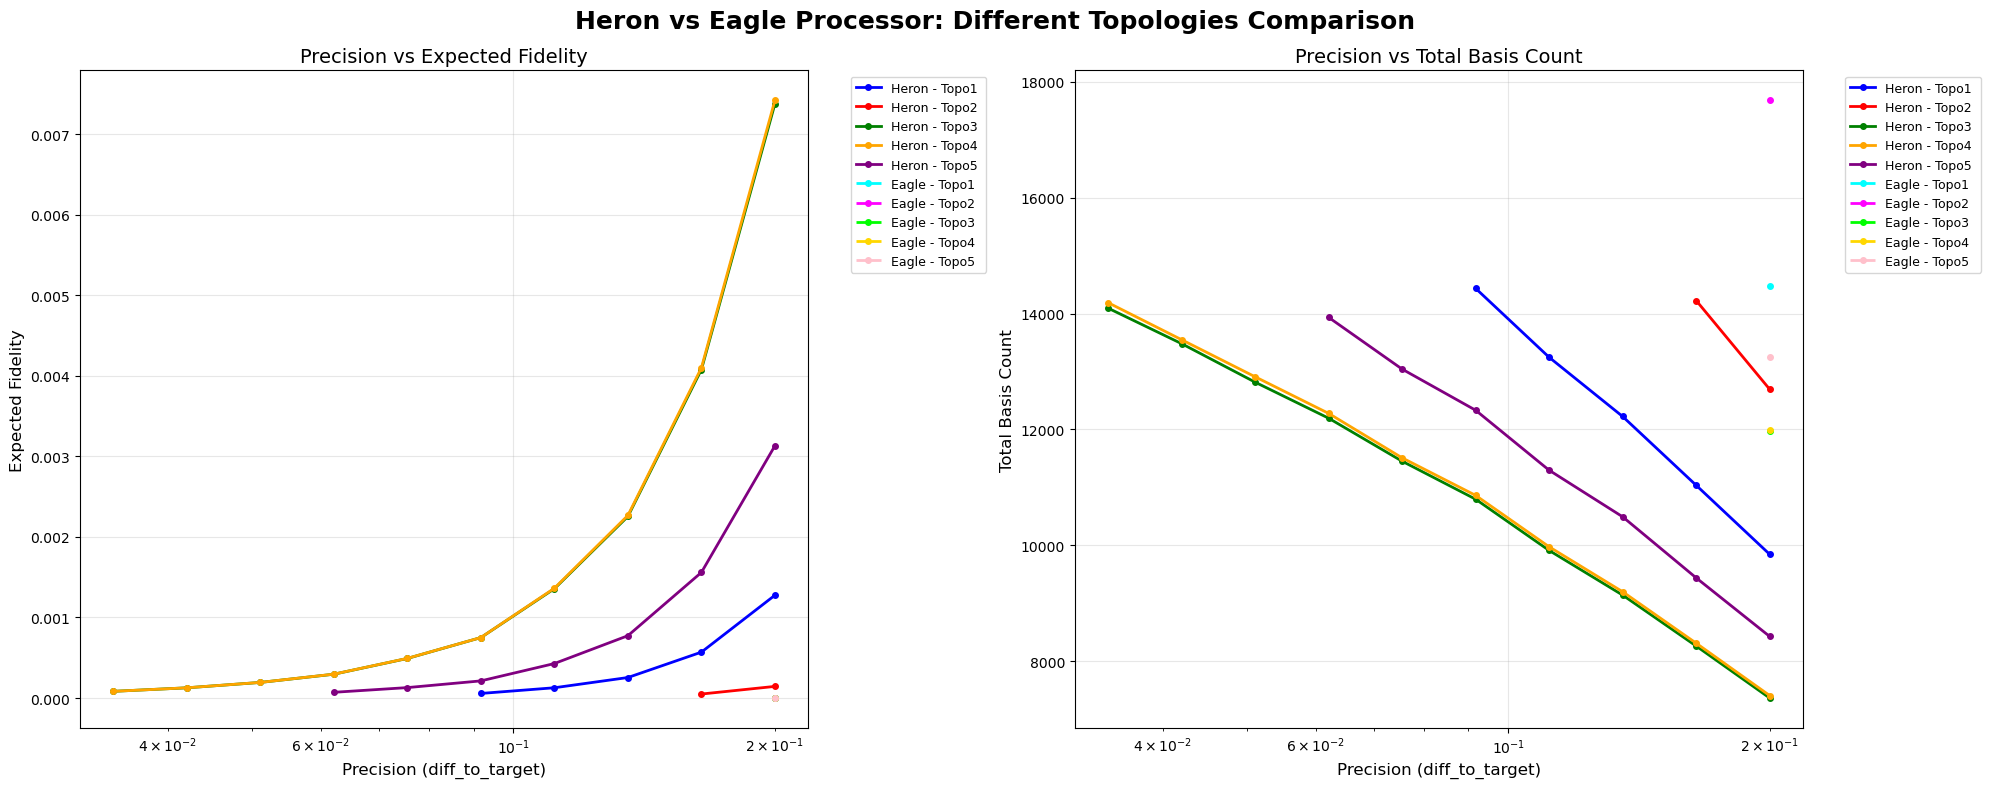


COMPREHENSIVE SUMMARY STATISTICS

HERON PROCESSOR RESULTS:
----------------------------------------
Topo1 :
  Maximum Fidelity: 0.001276
  Minimum Gate Count: 9844
  Data Points: 5
Topo2 :
  Maximum Fidelity: 0.000144
  Minimum Gate Count: 12693
  Data Points: 2
Topo3 :
  Maximum Fidelity: 0.007375
  Minimum Gate Count: 7363
  Data Points: 10
Topo4 :
  Maximum Fidelity: 0.007419
  Minimum Gate Count: 7406
  Data Points: 10
Topo5 :
  Maximum Fidelity: 0.003131
  Minimum Gate Count: 8426
  Data Points: 7

EAGLE PROCESSOR RESULTS:
----------------------------------------
Topo1 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 14483
  Data Points: 1
Topo2 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 17684
  Data Points: 1
Topo3 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11973
  Data Points: 1
Topo4 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11983
  Data Points: 1
Topo5 :
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 13254
  Data Points: 1

KEY INSIGHTS:

In [ ]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2 ": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5 ": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# 生成精度阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)

# 存储所有结果
all_results = {}

print("Testing different topologies for both Heron and Eagle Processors...")

# 对每个处理器和每个拓扑运行实验
for processor_name, processor_config in processors.items():
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    print("Gate median errors:")
    for gate, error in gate_error.items():
        print(f"  {gate}: {error}")
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} - {topo_name}"
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        fidelity_list = []
        total_count_list = []
        
        for threshold in precision_list:
            # 初始化电路
            qc_initial = uniform_superposition_circuit()
            
            # 运行 main_loop
            beta_list, energy_list, final_circuit = main_loop_2(
                qc=qc_initial,
                cost_h=cost_h,
                driver_h=driver_h,
                comm_h=comm_h,
                delta_t=delta_t,
                beta_0=beta_0,
                n_steps=n_steps,
                diff_threshold=threshold
            )

            # Transpile 电路
            transpiled_circuit = transpile(
                final_circuit,
                basis_gates=basis_gates,
                coupling_map=coupling_map,
                optimization_level=1
            )

            # 统计 gate count
            gate_counts = transpiled_circuit.count_ops()
            total_count = sum(gate_counts.values())
            total_count_list.append(total_count)

            # 计算 expected fidelity
            expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
            fidelity_list.append(expected_fidelity)
            
            # 如果保真度太低就提前退出
            if expected_fidelity < 0.0001:
                print(f"Expected fidelity reached threshold for {combined_name}, stopping early.")
                break
        
        # 存储结果
        all_results[combined_name] = {
            'precision': precision_list[:len(fidelity_list)],
            'fidelity': fidelity_list,
            'gate_count': total_count_list,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"{combined_name} completed with {len(fidelity_list)} data points")

# 绘制合并图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Heron vs Eagle Processor: Different Topologies Comparison', fontsize=18, fontweight='bold')

# 定义颜色和线型
heron_colors = ['blue', 'red', 'green', 'orange', 'purple']
eagle_colors = ['cyan', 'magenta', 'lime', 'gold', 'pink']
heron_linestyle = '-'
eagle_linestyle = '--'

# Plot 1: Precision vs Expected Fidelity
heron_results = []
eagle_results = []

for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[len(heron_results)]
        linestyle = heron_linestyle
        heron_results.append(combined_name)
    else:
        color = eagle_colors[len(eagle_results)]
        linestyle = eagle_linestyle
        eagle_results.append(combined_name)
    
    ax1.plot(results['precision'], results['fidelity'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Precision vs Expected Fidelity', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Plot 2: Precision vs Total Basis Count
for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[heron_results.index(combined_name)]
        linestyle = heron_linestyle
    else:
        color = eagle_colors[eagle_results.index(combined_name)]
        linestyle = eagle_linestyle
    
    ax2.plot(results['precision'], results['gate_count'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax2.set_xscale('log')
ax2.set_xlabel('Precision ', fontsize=12)
ax2.set_ylabel('Total Basis Count', fontsize=12)
ax2.set_title('Precision vs Total Basis Count', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# 打印汇总统计
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*80)

print("\nHERON PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\nEAGLE PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Eagle':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("• Heron processor uses solid lines (-), Eagle processor uses dashed lines (--)")
print("• Heron basis gates: ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']")
print("• Eagle basis gates: ['ecr', 'id', 'rz', 'sx', 'x']")
print("• Eagle ECR gate has higher error rate (5.824e-3) vs Heron CZ gate (1.947e-3)")
print("• Eagle single-qubit gates have slightly lower error rates")
print("• Different topologies show varying performance trade-offs between processors")

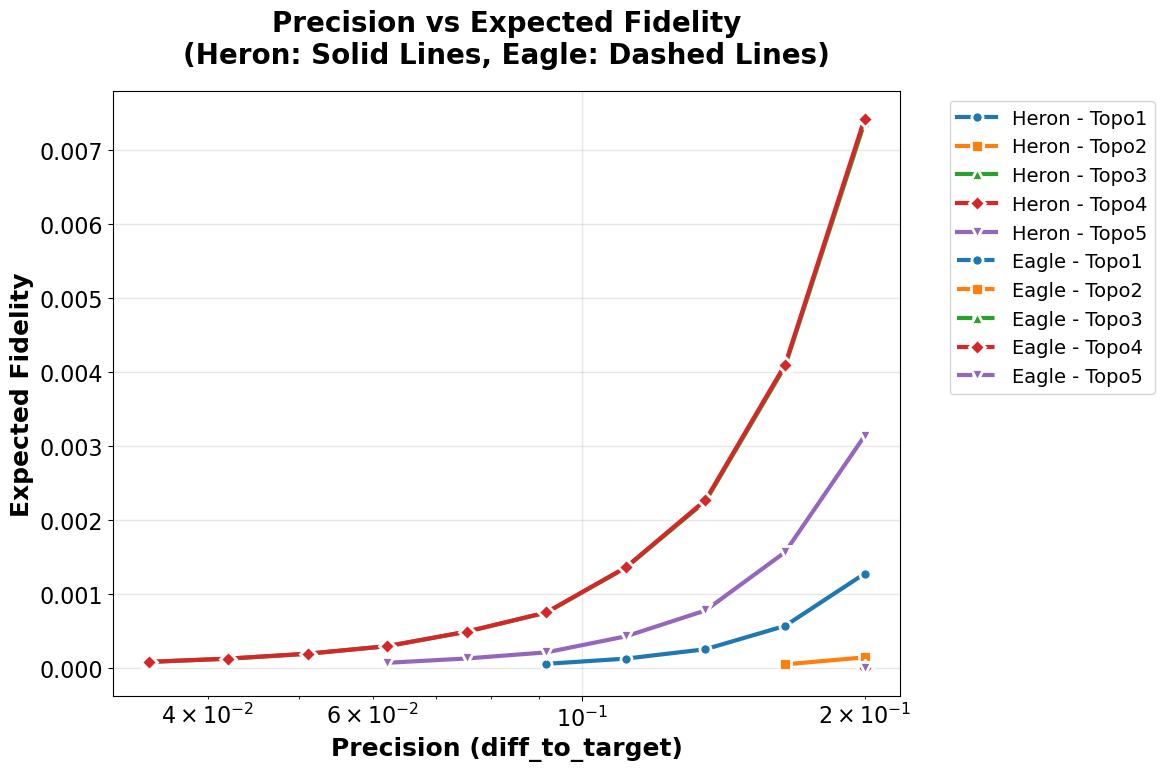

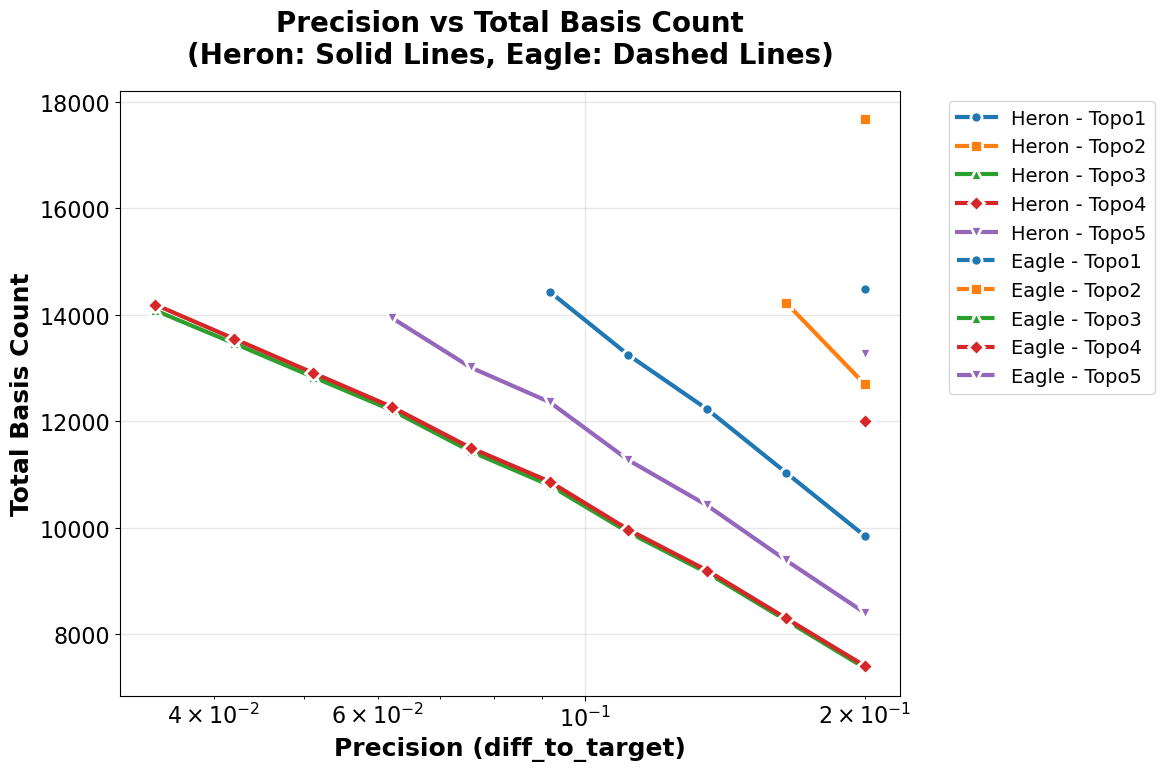

In [3]:
# 改进的绘图代码 - 替换原来的绘图部分
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# 设置更大的字体
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# 防色盲的颜色和标记样式
heron_styles = [
    {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-'},      # 蓝色，圆圈
    {'color': '#ff7f0e', 'marker': 's', 'linestyle': '-'},      # 橙色，方块
    {'color': '#2ca02c', 'marker': '^', 'linestyle': '-'},      # 绿色，三角形
    {'color': '#d62728', 'marker': 'D', 'linestyle': '-'},      # 红色，菱形
    {'color': '#9467bd', 'marker': 'v', 'linestyle': '-'}       # 紫色，倒三角形
]

eagle_styles = [
    {'color': '#1f77b4', 'marker': 'o', 'linestyle': '--'},     # 蓝色，圆圈，虚线
    {'color': '#ff7f0e', 'marker': 's', 'linestyle': '--'},     # 橙色，方块，虚线
    {'color': '#2ca02c', 'marker': '^', 'linestyle': '--'},     # 绿色，三角形，虚线
    {'color': '#d62728', 'marker': 'D', 'linestyle': '--'},     # 红色，菱形，虚线
    {'color': '#9467bd', 'marker': 'v', 'linestyle': '--'}      # 紫色，倒三角形，虚线
]

# 创建两个独立的图
fig1, ax1 = plt.subplots(figsize=(12, 8))
fig2, ax2 = plt.subplots(figsize=(12, 8))

# 绘制第一个图：Precision vs Expected Fidelity
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    else:
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    
    ax1.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=3, 
             markersize=8, label=combined_name, 
             markeredgewidth=2, markeredgecolor='white')

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)', fontweight='bold')
ax1.set_ylabel('Expected Fidelity', fontweight='bold')
ax1.set_title('Precision vs Expected Fidelity\n(Heron: Solid Lines, Eagle: Dashed Lines)', 
              fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linewidth=1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 绘制第二个图：Precision vs Total Basis Count
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    else:
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    
    ax2.plot(results['precision'], results['gate_count'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=3, 
             markersize=8, label=combined_name,
             markeredgewidth=2, markeredgecolor='white')

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)', fontweight='bold')
ax2.set_ylabel('Total Basis Count', fontweight='bold')
ax2.set_title('Precision vs Total Basis Count\n(Heron: Solid Lines, Eagle: Dashed Lines)', 
              fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linewidth=1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局并显示
plt.figure(fig1.number)
plt.tight_layout()
plt.figure(fig2.number)
plt.tight_layout()
plt.show()

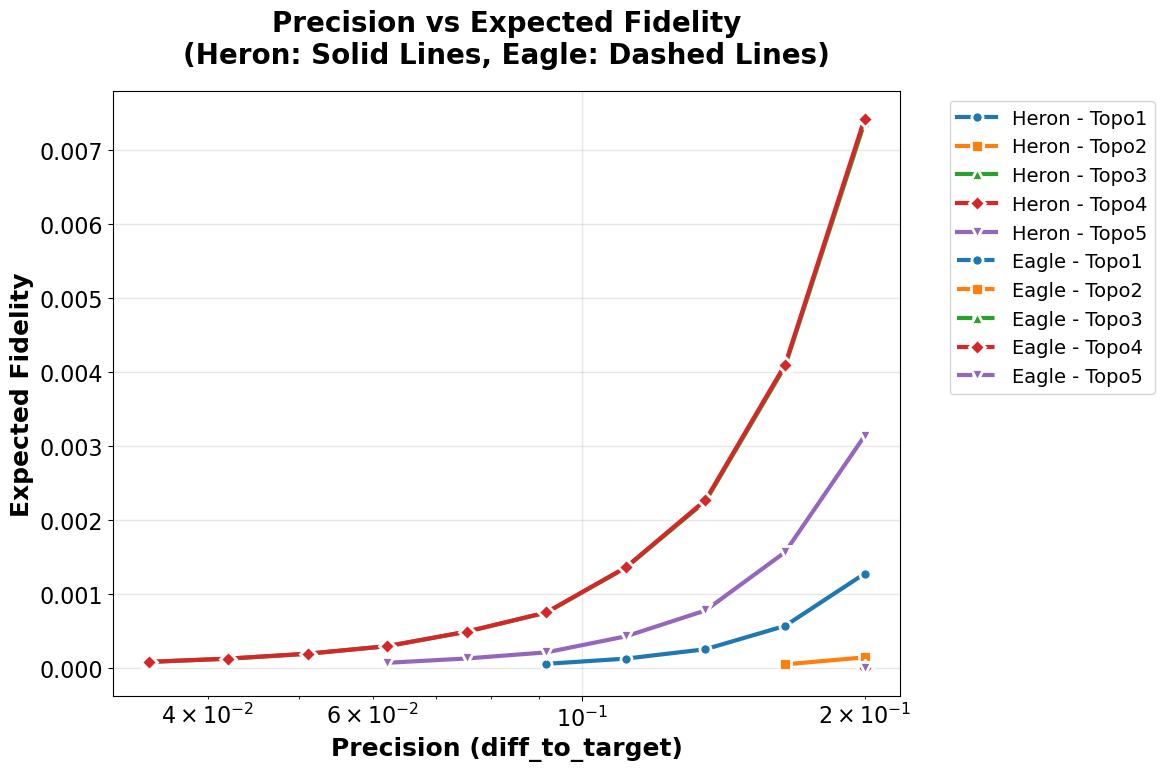

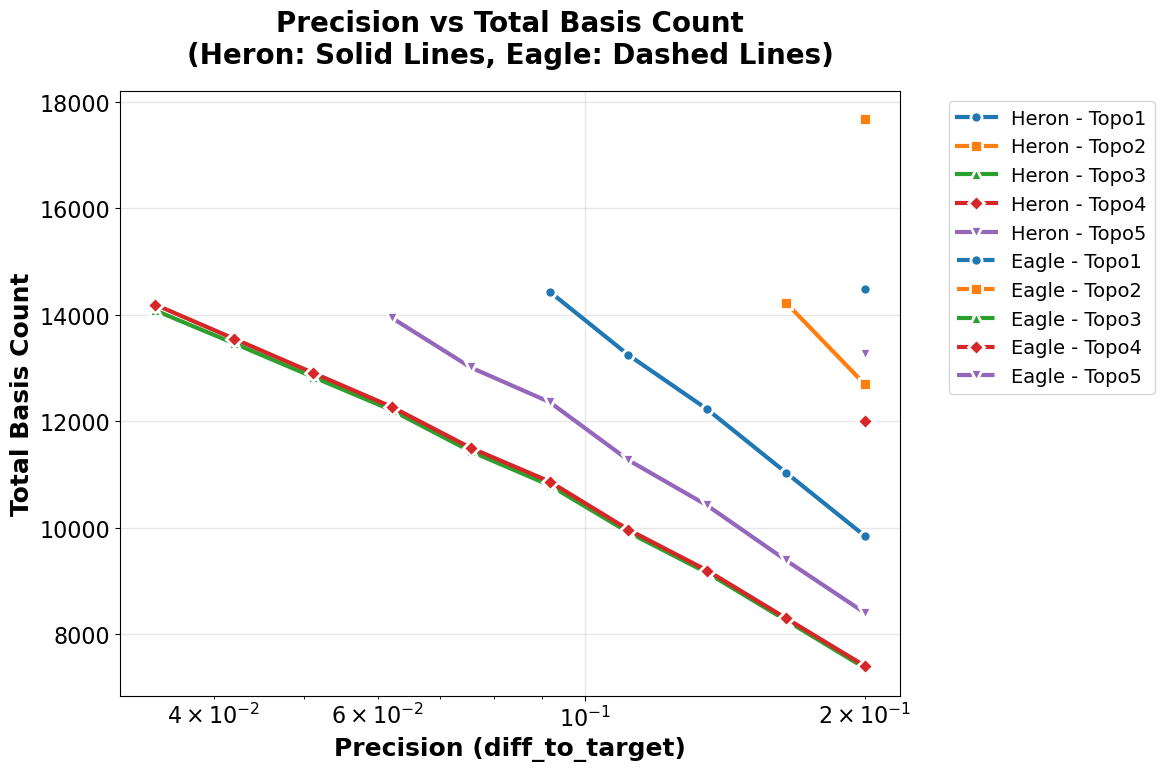

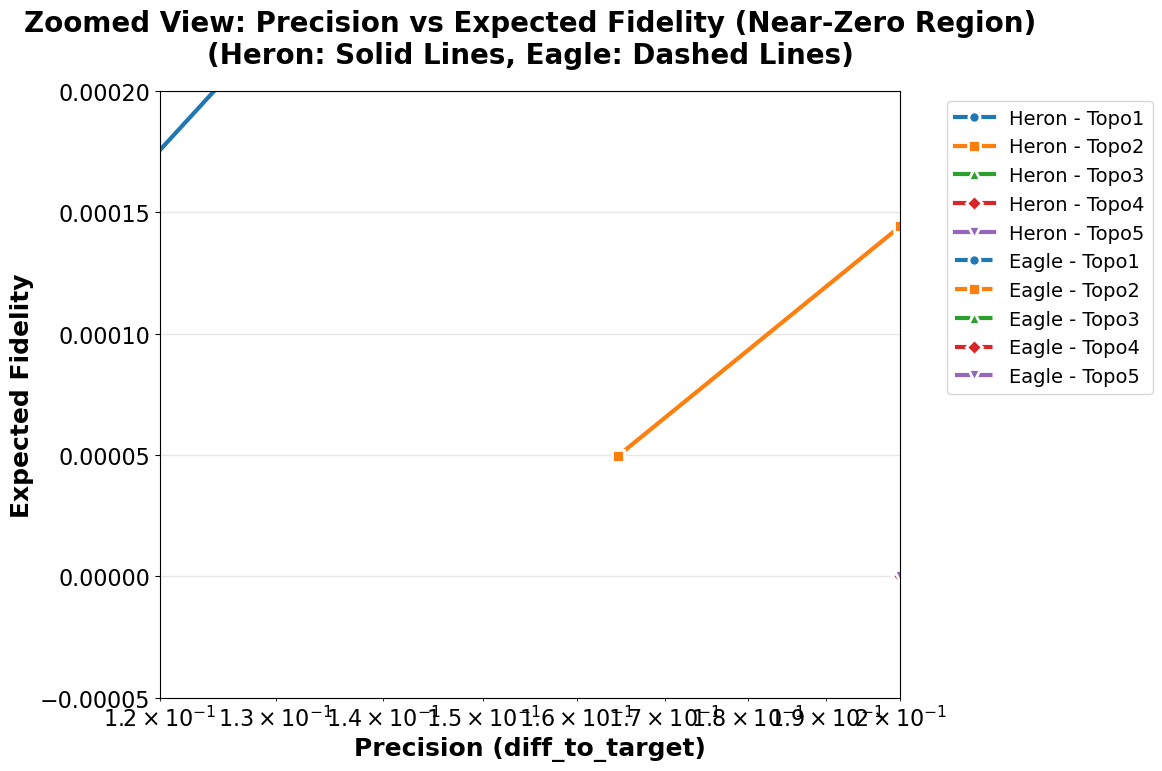

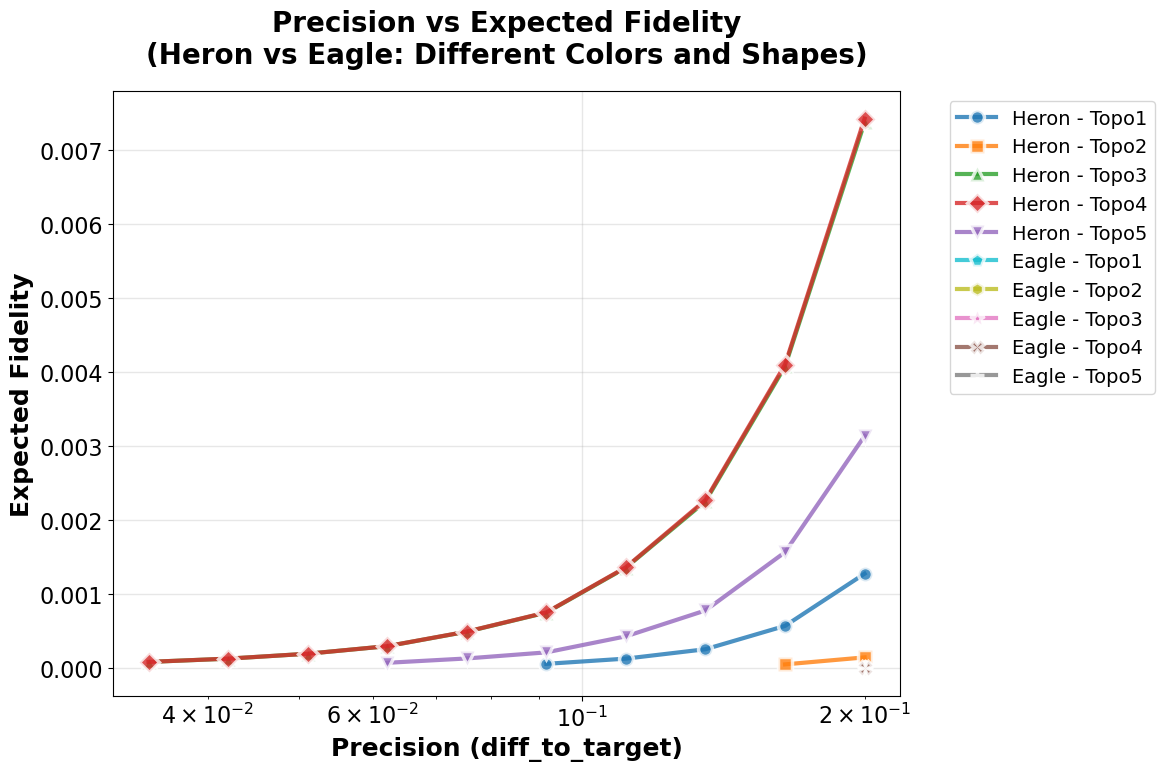

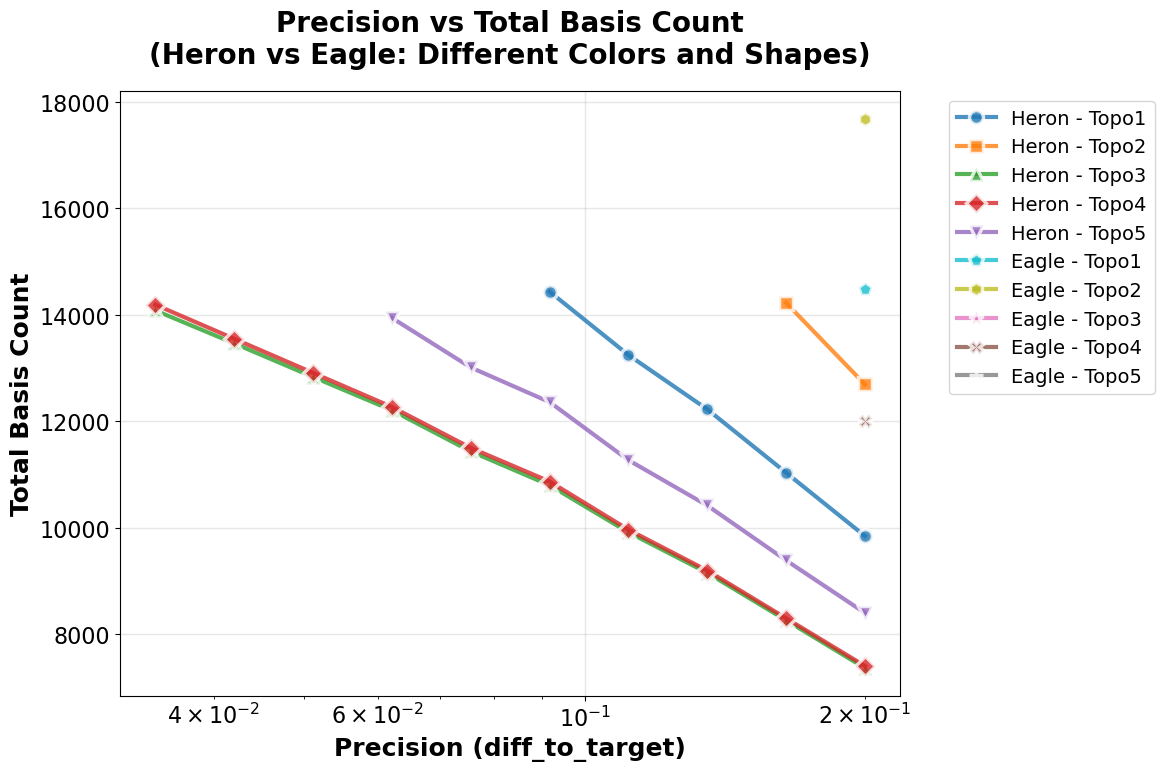

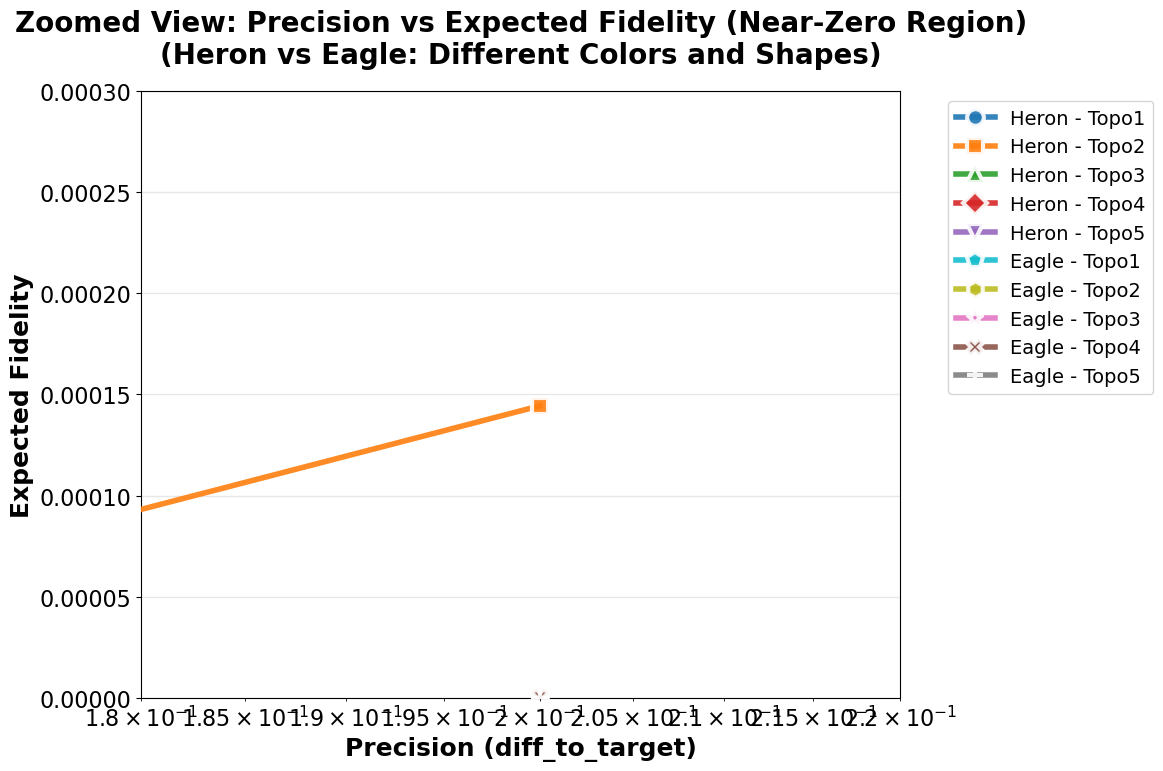

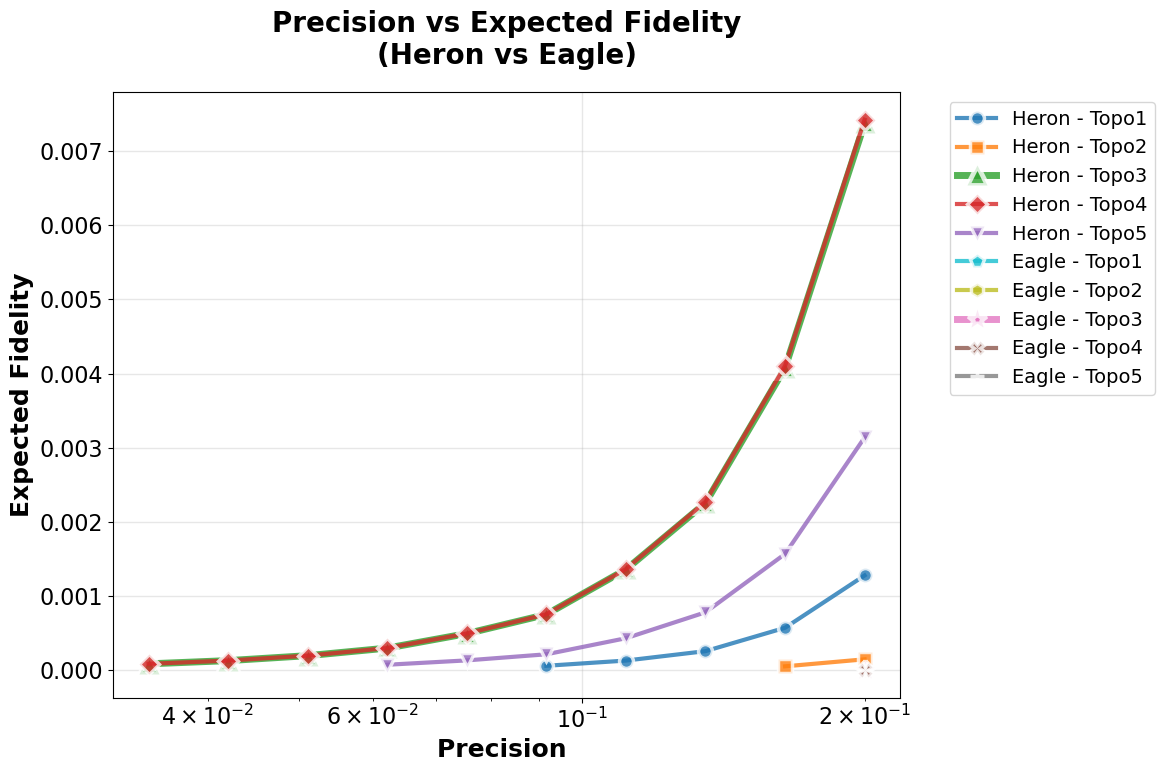

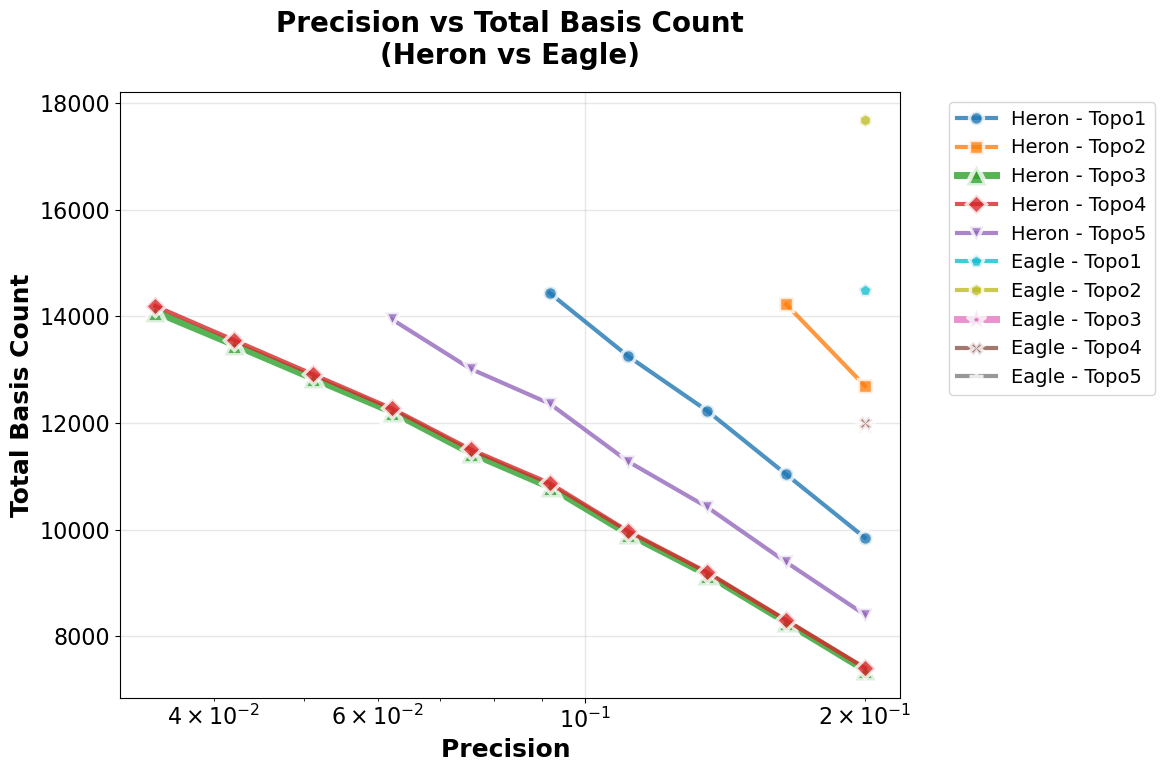

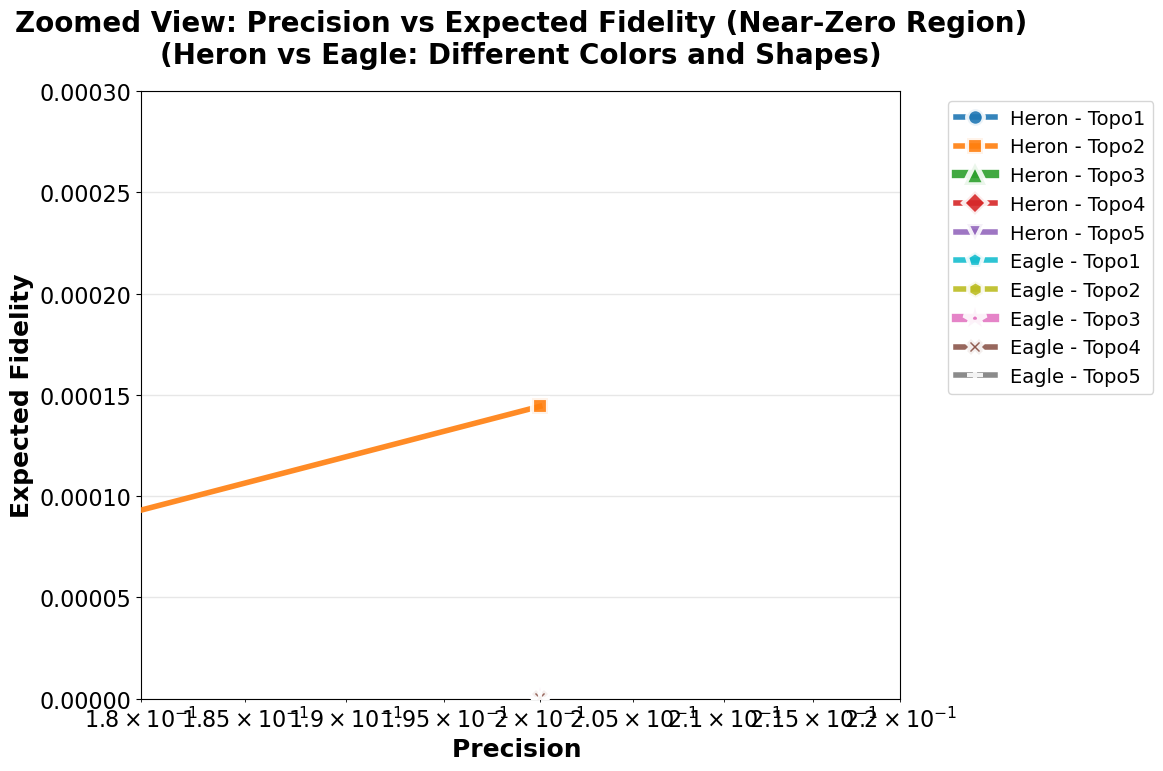

In [19]:
# 改进的绘图代码 - 替换原来的绘图部分
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# 设置更大的字体
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# 防色盲的颜色和标记样式 - 全部使用实线，不同颜色和形状区分
heron_styles = [
    {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-'},      # 蓝色，圆圈
    {'color': '#ff7f0e', 'marker': 's', 'linestyle': '-'},      # 橙色，方块
    {'color': '#2ca02c', 'marker': '^', 'linestyle': '-'},      # 绿色，三角形
    {'color': '#d62728', 'marker': 'D', 'linestyle': '-'},      # 红色，菱形
    {'color': '#9467bd', 'marker': 'v', 'linestyle': '-'}       # 紫色，倒三角形
]

eagle_styles = [
    {'color': '#17becf', 'marker': 'p', 'linestyle': '-'},      # 青色，五角星
    {'color': '#bcbd22', 'marker': 'h', 'linestyle': '-'},      # 橄榄色，六边形
    {'color': '#e377c2', 'marker': '*', 'linestyle': '-'},      # 粉色，星号
    {'color': '#8c564b', 'marker': 'X', 'linestyle': '-'},      # 棕色，X形
    {'color': '#7f7f7f', 'marker': '+', 'linestyle': '-'}       # 灰色，加号
]

# 创建两个独立的图
fig1, ax1 = plt.subplots(figsize=(12, 8))
fig2, ax2 = plt.subplots(figsize=(12, 8))

# 绘制第一个图：Precision vs Expected Fidelity
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    else:
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax1.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('Precision ', fontweight='bold')
ax1.set_ylabel('Expected Fidelity', fontweight='bold')
ax1.set_title('Precision vs Expected Fidelity\n(Heron vs Eagle)', 
              fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linewidth=1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 绘制第二个图：Precision vs Total Basis Count
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    else:
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax2.plot(results['precision'], results['gate_count'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name,
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax2.set_xscale('log')
ax2.set_xlabel('Precision ', fontweight='bold')
ax2.set_ylabel('Total Basis Count', fontweight='bold')
ax2.set_title('Precision vs Total Basis Count\n(Heron vs Eagle)', 
              fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linewidth=1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 创建第三个图：放大拥挤区域
fig3, ax3 = plt.subplots(figsize=(12, 8))

# 绘制放大的拥挤区域
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    else:
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 6
        markersize = 16
        markeredgewidth = 4
    else:
        linewidth = 4
        markersize = 12
        markeredgewidth = 3
    
    ax3.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.9, markevery=1)

# 设置放大区域的范围 - 专注在0.2附近的x值和0以上的y值
ax3.set_xlim(0.18, 0.22)  # 专注在0.2这个区域
ax3.set_ylim(0.0, 0.0003)  # 只关心0以上的值

ax3.set_xscale('log')
ax3.set_xlabel('Precision ', fontweight='bold')
ax3.set_ylabel('Expected Fidelity', fontweight='bold')
ax3.set_title('Zoomed View: Precision vs Expected Fidelity (Near-Zero Region)\n(Heron vs Eagle: Different Colors and Shapes)', 
              fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, linewidth=1)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局并显示
plt.figure(fig1.number)
plt.tight_layout()
plt.figure(fig2.number)
plt.tight_layout()
plt.figure(fig3.number)
plt.tight_layout()
plt.show()